In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are
import cvxpy as cp
from algorithms import policy_fitting, policy_fitting_with_a_kalman_constraint
import warnings
import random
# warnings.filterwarnings('ignore')

In [2]:
np.random.seed(0)
n, m = 4, 2
A = np.random.randn(n, n)
A = A / np.abs(np.linalg.eig(A)[0]).max()
B = np.random.randn(n, m)
W = .25 * np.eye(n)
Q_true = np.eye(n)
R_true = np.eye(m)
P_true = solve_discrete_are(A, B, Q_true, R_true)
K_true = -np.linalg.solve(R_true + B.T @ P_true @ B, B.T @ P_true @ A)

In [3]:
def simulate(K, N=10, seed=None, add_noise=False):
    if seed is not None:
        np.random.seed(seed)
    x = np.random.multivariate_normal(np.zeros(n), W)
    xs = []
    us = []
    cost = 0.0
    for _ in range(N):
        u = K @ x
        if add_noise:
            u += np.random.randn(m)
            for i in range(m):
                if random.random() < .1:
                    u[i] *= -1.
        xs.append(x)
        us.append(u)
        cost += (x @ Q_true @ x + u @ R_true @ u) / N
        x = A @ x + B @ u + np.random.multivariate_normal(np.zeros(n), W)
    xs = np.array(xs)
    us = np.array(us)
    
    return cost, xs, us

In [4]:
N_test = 10000
cost_true = simulate(K_true, N=N_test, seed=0)[0]
cost_noise = simulate(K_true, N=N_test, seed=0, add_noise=True)[0] 
cost_true, np.trace(P_true @ W), cost_noise

(1.7934243186095473, 1.8031177219720198, 18.843574655303694)

In [5]:
costs_lr = []
costs_admm = []
Ns = np.arange(1, 51)
for N in Ns:
    costs_lr += [[]]
    costs_admm += [[]]
    for k in range(1, 11):
        _, xs, us = simulate(K_true, N=N, seed=k, add_noise=True)

        def L(K):
            return cp.sum(cp.huber(xs @ K.T - us, .5))

        def r(K):
            return .01 * cp.sum_squares(K), []
        
        Klr = policy_fitting(L, r, xs, us)
        Kadmm = policy_fitting_with_a_kalman_constraint(L, r, xs, us, A, B, n_random=5)
        
        cost_lr = simulate(Klr, N=N_test, seed=0)[0]
        cost_admm = simulate(Kadmm, N=N_test, seed=0)[0]
        
        if np.isnan(cost_lr) or cost_lr > 1e5 or cost_lr == np.inf:
            cost_lr = np.nan

        costs_lr[-1].append(cost_lr)
        costs_admm[-1].append(cost_admm)

    print (" %03d | %3.3f | %3.3f | %3.3f | %3.3f" %
           (N, cost_true, cost_noise, np.nanmean(costs_lr[-1]), np.nanmean(costs_admm[-1])))

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ip

 001 | 1.793 | 18.844 | 17.885 | 12.460


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in 

 002 | 1.793 | 18.844 | nan | 5.939


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/s

 003 | 1.793 | 18.844 | 7.186 | 13.508


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ip

 004 | 1.793 | 18.844 | nan | 5.550


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarni

 005 | 1.793 | 18.844 | 23.483 | 4.465


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ip

 006 | 1.793 | 18.844 | 8.436 | 5.246


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_

 007 | 1.793 | 18.844 | 14.981 | 3.904


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul


 008 | 1.793 | 18.844 | 44.475 | 3.737
 009 | 1.793 | 18.844 | 8.096 | 5.146


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul


 010 | 1.793 | 18.844 | 7.092 | 3.135


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul


 011 | 1.793 | 18.844 | 4.656 | 2.752


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add


 012 | 1.793 | 18.844 | 6.547 | 2.731


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul


 013 | 1.793 | 18.844 | 4.346 | 3.240
 014 | 1.793 | 18.844 | 4.186 | 2.582
 015 | 1.793 | 18.844 | 4.730 | 2.506


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add


 016 | 1.793 | 18.844 | 5.530 | 2.540
 017 | 1.793 | 18.844 | 4.583 | 2.231
 018 | 1.793 | 18.844 | 5.089 | 2.397
 019 | 1.793 | 18.844 | 3.373 | 2.460
 020 | 1.793 | 18.844 | 3.626 | 2.414
 021 | 1.793 | 18.844 | 3.115 | 2.358
 022 | 1.793 | 18.844 | 2.847 | 2.011
 023 | 1.793 | 18.844 | 3.375 | 2.268
 024 | 1.793 | 18.844 | 3.482 | 2.168
 025 | 1.793 | 18.844 | 2.926 | 2.216
 026 | 1.793 | 18.844 | 2.755 | 2.040
 027 | 1.793 | 18.844 | 2.742 | 2.052
 028 | 1.793 | 18.844 | 3.026 | 2.197
 029 | 1.793 | 18.844 | 2.875 | 2.171
 030 | 1.793 | 18.844 | 2.621 | 2.190
 031 | 1.793 | 18.844 | 2.257 | 2.022
 032 | 1.793 | 18.844 | 2.599 | 2.088
 033 | 1.793 | 18.844 | 2.734 | 2.015
 034 | 1.793 | 18.844 | 2.717 | 2.089
 035 | 1.793 | 18.844 | 2.907 | 2.125
 036 | 1.793 | 18.844 | 2.222 | 2.082
 037 | 1.793 | 18.844 | 2.725 | 2.244
 038 | 1.793 | 18.844 | 2.208 | 2.001
 039 | 1.793 | 18.844 | 2.505 | 2.090
 040 | 1.793 | 18.844 | 2.505 | 2.148
 041 | 1.793 | 18.844 | 2.787 | 2.143
 042 | 1.793

In [6]:
costs_lr = np.array(costs_lr)
costs_admm = np.array(costs_admm)

In [7]:
mean_lr = np.nanmean(costs_lr, axis=1)
std_lr = np.nanstd(costs_lr, axis=1)

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/shane/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [8]:
mean_admm = np.nanmean(costs_admm, axis=1)
std_admm = np.nanstd(costs_admm, axis=1)

In [9]:
mean_lr

array([17.88463834,         nan,  7.18602901,         nan, 23.48261452,
        8.43584694, 14.98148877, 44.47505642,  8.09576731,  7.09242333,
        4.65626538,  6.54669287,  4.34611455,  4.1863064 ,  4.72997278,
        5.53025179,  4.58330659,  5.0887345 ,  3.37287197,  3.62599819,
        3.11517781,  2.84727996,  3.37546613,  3.48181687,  2.92574885,
        2.75487631,  2.74222125,  3.02597631,  2.87451904,  2.62140487,
        2.256775  ,  2.59888811,  2.73445555,  2.71662962,  2.90696657,
        2.22220488,  2.72455813,  2.20759909,  2.50477256,  2.50513696,
        2.78686451,  2.50792071,  2.55167904,  2.46288925,  2.40123814,
        2.52599536,  2.41258949,  2.54318388,  2.55086983,  2.35601662])

In [10]:
mean_admm

array([12.45959713,  5.93878182, 13.50770644,  5.54994686,  4.46539205,
        5.24565854,  3.90446968,  3.73663023,  5.14603724,  3.13525122,
        2.75150153,  2.73085728,  3.24015797,  2.58176305,  2.5063684 ,
        2.5403887 ,  2.23128929,  2.39725499,  2.46030853,  2.4138163 ,
        2.35750845,  2.01065232,  2.26794575,  2.16815446,  2.21592664,
        2.04005193,  2.05175912,  2.19655304,  2.17100166,  2.19012607,
        2.0224732 ,  2.08761477,  2.01504809,  2.08861192,  2.12512687,
        2.0815756 ,  2.24416754,  2.00102876,  2.08988599,  2.14763068,
        2.14307852,  2.04734498,  2.15254947,  2.08572251,  2.01685283,
        2.08045657,  2.00648745,  1.99115469,  1.97527556,  1.92429379])

In [11]:
# mean_admm = np.load("mean_admm.npy")
# mean_lr = np.load("mean_lr.npy")
# std_admm = np.load("std_admm.npy")
# std_lr = np.load("std_lr.npy")
# costs_lr = np.load("costs_lr.npy")
# costs_admm = np.load("costs_admm.npy")

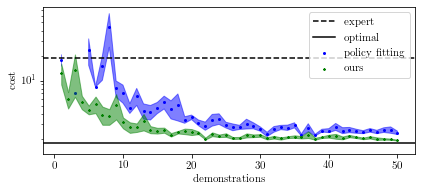

In [14]:
from utils import latexify
import matplotlib.pyplot as plt

plt.close()
latexify(fig_width=6, fig_height=2.8)
plt.axhline(cost_noise, ls='--', c='k', label='expert')
plt.scatter(np.arange(1,51), mean_lr, s=4, marker='o', c='blue', label='policy fitting')
plt.fill_between(np.arange(1,51), mean_lr - std_lr / 3, mean_lr + std_lr / 3, alpha=.5, color='blue')
plt.scatter(np.arange(1,51), mean_admm, s=4, marker='*', c='green', label='ours')
plt.fill_between(np.arange(1,51), mean_admm - std_admm / 3, mean_admm + std_admm / 3, alpha=.5, color='green')
plt.semilogy()
plt.axhline(cost_true, ls='-', c='k', label='optimal')
plt.ylabel('cost')
plt.xlabel('demonstrations')
plt.legend()
plt.tight_layout()
plt.savefig("figs/flip.pdf")
plt.show()

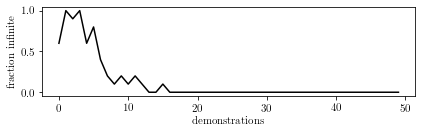

In [15]:
plt.close()
latexify(fig_width=6, fig_height=2)
plt.plot(np.isnan(costs_lr).mean(axis=1), c='k')
plt.xlabel("demonstrations")
plt.ylabel("fraction infinite")
plt.tight_layout()
plt.savefig("figs/inf_flip.pdf")